In [2]:
# libraries needed to be installed:

library(tidyverse)
library(repr)
library(rvest)
library(stringr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(ggplot2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘rvest’ was built under R version 4.0.2”
Loading required package: xml2


Attaching package: ‘rvest’


The following object is masked from ‘package:purrr’:

    pluck


The following object is masked from ‘package:readr’:

    guess_encoding


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
─

In [3]:
# wrangling

library(readxl)
url <- 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
download.file(url, destfile = "processed.cleveland.data")

heart_data <- read.table("processed.cleveland.data", sep = ",") %>%
rename(
age = V1, # (years)
sex = V2, # 1 == male, 0 == female
chest_pain_type = V3, # 1 == typical angina, 2 == atypical angina, 3 == non-anginal pain, 4 == asymptomatic
resting_blood_pressure = V4, # (mmHg)
cholesterol_level = V5, # (mg/dl)
fasting_blood_sugar = V6, # 1 == higher than 120 mg/dl, 0 == not higher than 120 mg/dl
resting_electrocardiographic_results = V7, # 0 == normal, 1 == ST-T wave abnormality, 2 == probable or definite left ventricular hypertrophy
maximum_heart_rate_achieved = V8, # (bpm?) *unit not stated
exercise_induced_angina = V9, # 1 == yes, 0 == no
excercise_induced_ST_depression = V10, # *unit not stated
slope = V11, # slope of the peak exercise ST segment. 1 == upsloping, 2 == flat, 3 == downsloping
major_vessels_coloured = V12, # number of major vessels (0-3) colored by flourosopy
thal = V13, # 3 == normal, 6 == fixed defect, 7 == reversable defect
diagnosis = V14) %>% # 0 == no heart disease, 1 to 4 == heart disease, with different levels of severity (4 is most severe)

na.omit(age, resting_blood_pressure, cholesterol_level) %>%
select(age, resting_blood_pressure, cholesterol_level, diagnosis) %>%
mutate(diagnosis = as.factor(diagnosis))
    
heart_data

age,resting_blood_pressure,cholesterol_level,diagnosis
<dbl>,<dbl>,<dbl>,<fct>
63,145,233,0
67,160,286,2
67,120,229,1
⋮,⋮,⋮,⋮
57,130,131,3
57,130,236,1
38,138,175,0


`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,n
<fct>,<int>
0,123
1,41
2,27
3,27
4,11


.,.
<chr>,<dbl>
mean age,54.039301
standard deviation age,9.207321
mean resting bp,131.755459
standard deviation resting bp,17.923119
mean cholesterol,248.100437
standard deviation cholesterol,53.210963


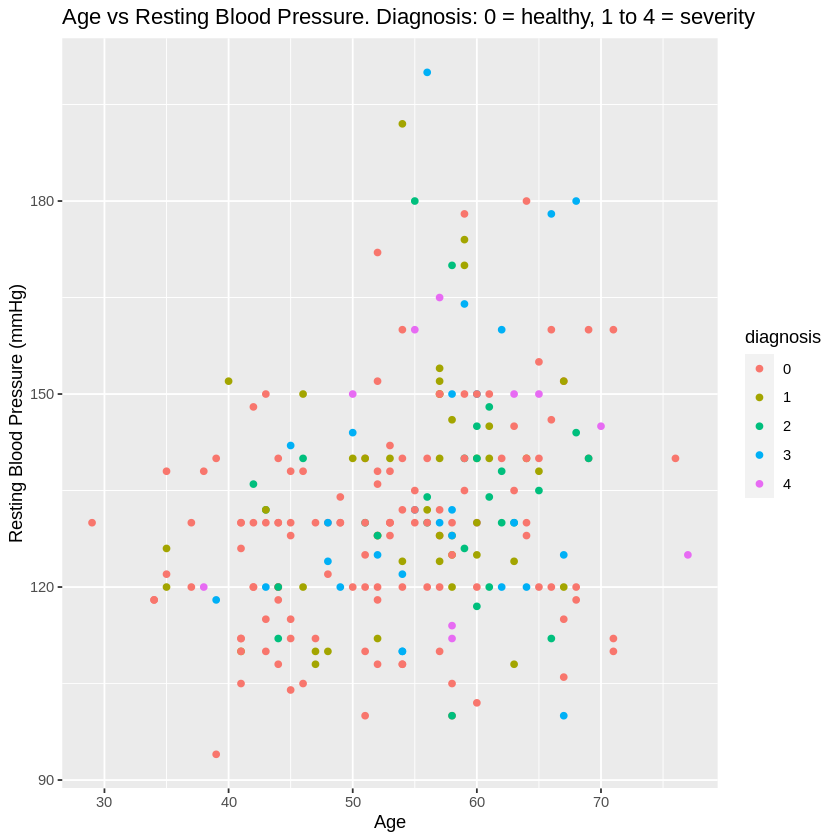

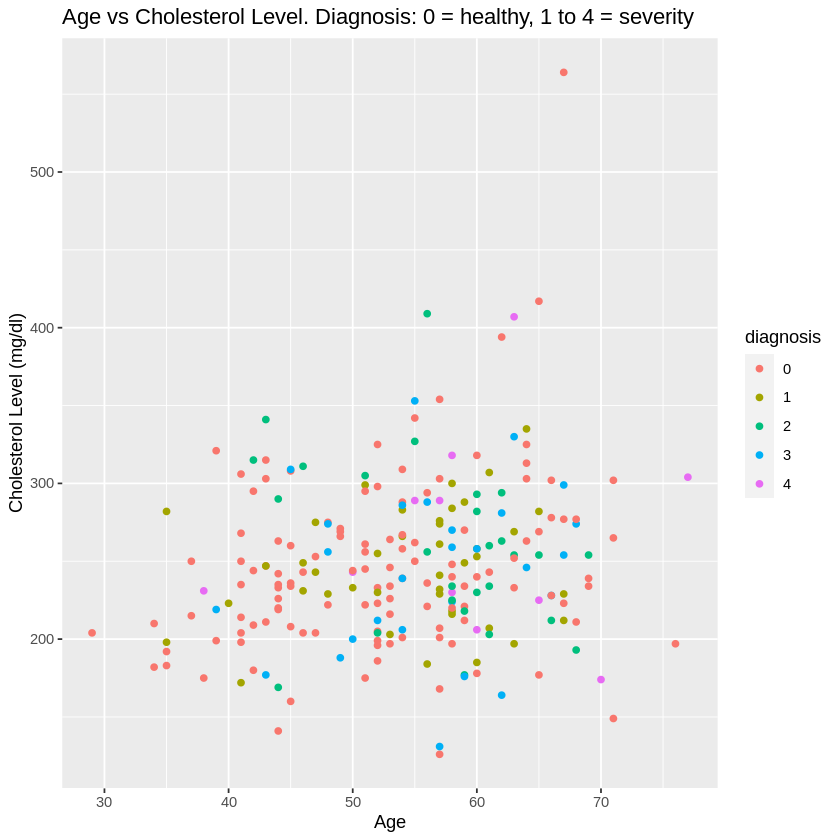

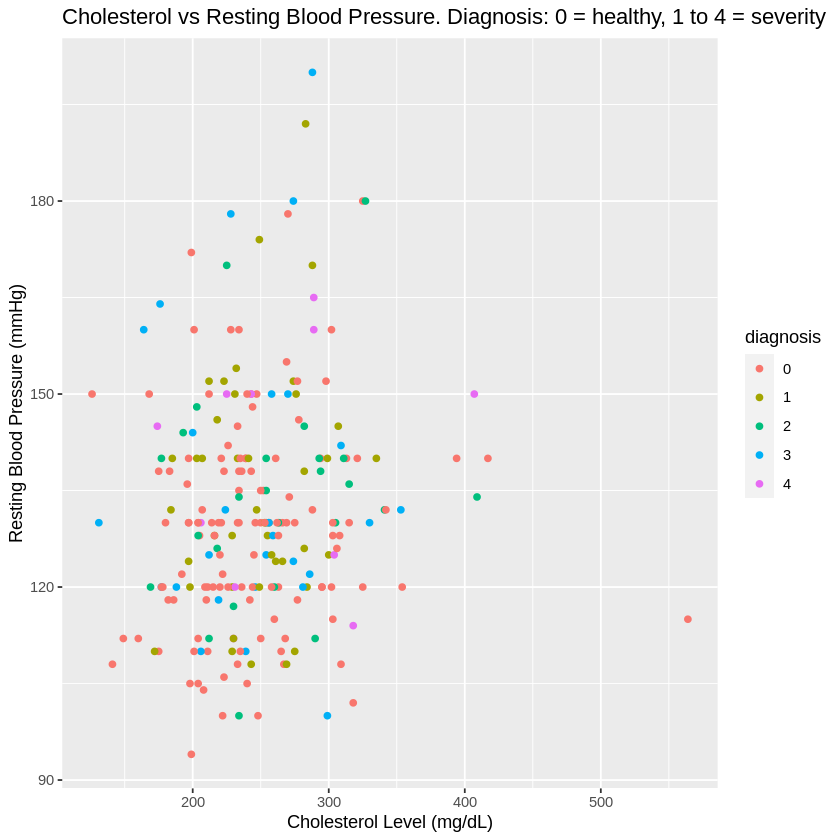

In [4]:
#Preliminary exploratory data analysis and visualizations:

set.seed(9) 

heart_split <- initial_split(heart_data, prop = 0.75, strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

diagnosis_count <- heart_train %>%
group_by(diagnosis) %>%
summarize(n = n())
diagnosis_count

mean_age <- mean(heart_train$age)
standard_deviation_age <- sd(heart_train$age)

mean_resting_bp <- mean(heart_train$resting_blood_pressure)
standard_deviation_resting_bp <- sd(heart_train$resting_blood_pressure)

mean_cholesterol <- mean(heart_train$cholesterol_level)
standard_deviation_cholesterol <- sd(heart_train$cholesterol_level)

predictor_labels <- c('mean age', 'standard deviation age', 'mean resting bp', 'standard deviation resting bp', 'mean cholesterol', 'standard deviation cholesterol') %>%
data.frame() 
predictor_info <- c(mean_age, standard_deviation_age, mean_resting_bp, standard_deviation_resting_bp, mean_cholesterol, standard_deviation_cholesterol) %>%
data.frame() 
predictor_table <- cbind(predictor_labels, predictor_info)
predictor_table

age_vs_resting_bp_plot <- ggplot(heart_train, aes(x=age, y=resting_blood_pressure, color = diagnosis)) +
geom_point() +
xlab('Age') +
ylab('Resting Blood Pressure (mmHg)') +
ggtitle('Age vs Resting Blood Pressure. Diagnosis: 0 = healthy, 1 to 4 = severity') 
age_vs_resting_bp_plot

age_vs_cholesterol_plot <- ggplot(heart_train, aes(x=age, y=cholesterol_level, color = diagnosis)) +
geom_point() +
xlab('Age') +
ylab('Cholesterol Level (mg/dl)') +
ggtitle('Age vs Cholesterol Level. Diagnosis: 0 = healthy, 1 to 4 = severity') 
age_vs_cholesterol_plot

cholesterol_vs_resting_bp_plot <- ggplot(heart_train, aes(x=cholesterol_level, y=resting_blood_pressure, color = diagnosis)) +
geom_point() +
xlab('Cholesterol Level (mg/dL)') +
ylab('Resting Blood Pressure (mmHg)') +
ggtitle('Cholesterol vs Resting Blood Pressure. Diagnosis: 0 = healthy, 1 to 4 = severity')
cholesterol_vs_resting_bp_plot

In [5]:
# trial classification with k = 3 neighbours, accuracy assessment

# recipe:
heart_recipe <- recipe(diagnosis ~. , data = heart_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

# model:
knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 3) %>%
       set_engine('kknn') %>%
       set_mode('classification')

# workflow & fit:
heart_fit <- workflow() %>%
       add_recipe(heart_recipe) %>%
       add_model(knn_spec) %>%
       fit(data = heart_train)

# predictions:
heart_test_predictions <- predict(heart_fit , heart_test) %>%
       bind_cols(heart_test)

# accuracy assessment (tibble):
heart_prediction_accuracy <- heart_test_predictions %>%
         metrics(truth = diagnosis, estimate = .pred_class) 

# accuracy assessment (confusion matrix):
heart_mat <- heart_test_predictions %>% 
       conf_mat(truth = diagnosis, estimate = .pred_class)

heart_prediction_accuracy
heart_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.37837838
kap,multiclass,0.04058625


          Truth
Prediction  0  1  2  3  4
         0 22  7  4  6  0
         1  8  3  1  1  1
         2  5  1  1  0  0
         3  3  1  2  1  0
         4  3  2  1  0  1

In [6]:
# vfold:
heart_vfold <- vfold_cv(heart_train, v = 10, strata = diagnosis)

In [7]:
# cross-validation:
heart_resample_fit <- workflow() %>%
       add_recipe(heart_recipe) %>%
       add_model(knn_spec) %>%
       fit_resamples(resamples = heart_vfold)

! Fold02: internal: No observations were detected in `truth` for level(s): '4'
Com...

! Fold03: internal: No observations were detected in `truth` for level(s): '4'
Com...

! Fold07: internal: No observations were detected in `truth` for level(s): '4'
Com...



In [8]:
#accuracy assessment of the cross-validation:
heart_metrics <- collect_metrics(heart_resample_fit)

In [9]:
# model for tuning:
knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
       set_engine('kknn') %>%
       set_mode('classification')

In [13]:
# gridvals
gridvals <- tibble(neighbors = seq(1,50))
gridvals

neighbors
<int>
1
2
3
⋮
48
49
50


In [14]:
# tuning:
knn_results <- workflow() %>%
       add_recipe(heart_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = heart_vfold, grid = gridvals) %>%
       collect_metrics()
knn_results

! Fold02: internal: No observations were detected in `truth` for level(s): '4'
Com...

! Fold03: internal: No observations were detected in `truth` for level(s): '4'
Com...

! Fold07: internal: No observations were detected in `truth` for level(s): '4'
Com...



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.3929513,10,0.02410113,Model01
1,roc_auc,hand_till,0.5224985,10,0.01667326,Model01
2,accuracy,multiclass,0.3929513,10,0.02410113,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
49,roc_auc,hand_till,0.5096968,10,0.020445784,Model49
50,accuracy,multiclass,0.5370059,10,0.008622644,Model50
50,roc_auc,hand_till,0.5078514,10,0.018903650,Model50


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.3929513,10,0.02410113,Model01
2,accuracy,multiclass,0.3929513,10,0.02410113,Model02
3,accuracy,multiclass,0.4495553,10,0.01111388,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,accuracy,multiclass,0.5370059,10,0.008622644,Model48
49,accuracy,multiclass,0.5370059,10,0.008622644,Model49
50,accuracy,multiclass,0.5370059,10,0.008622644,Model50


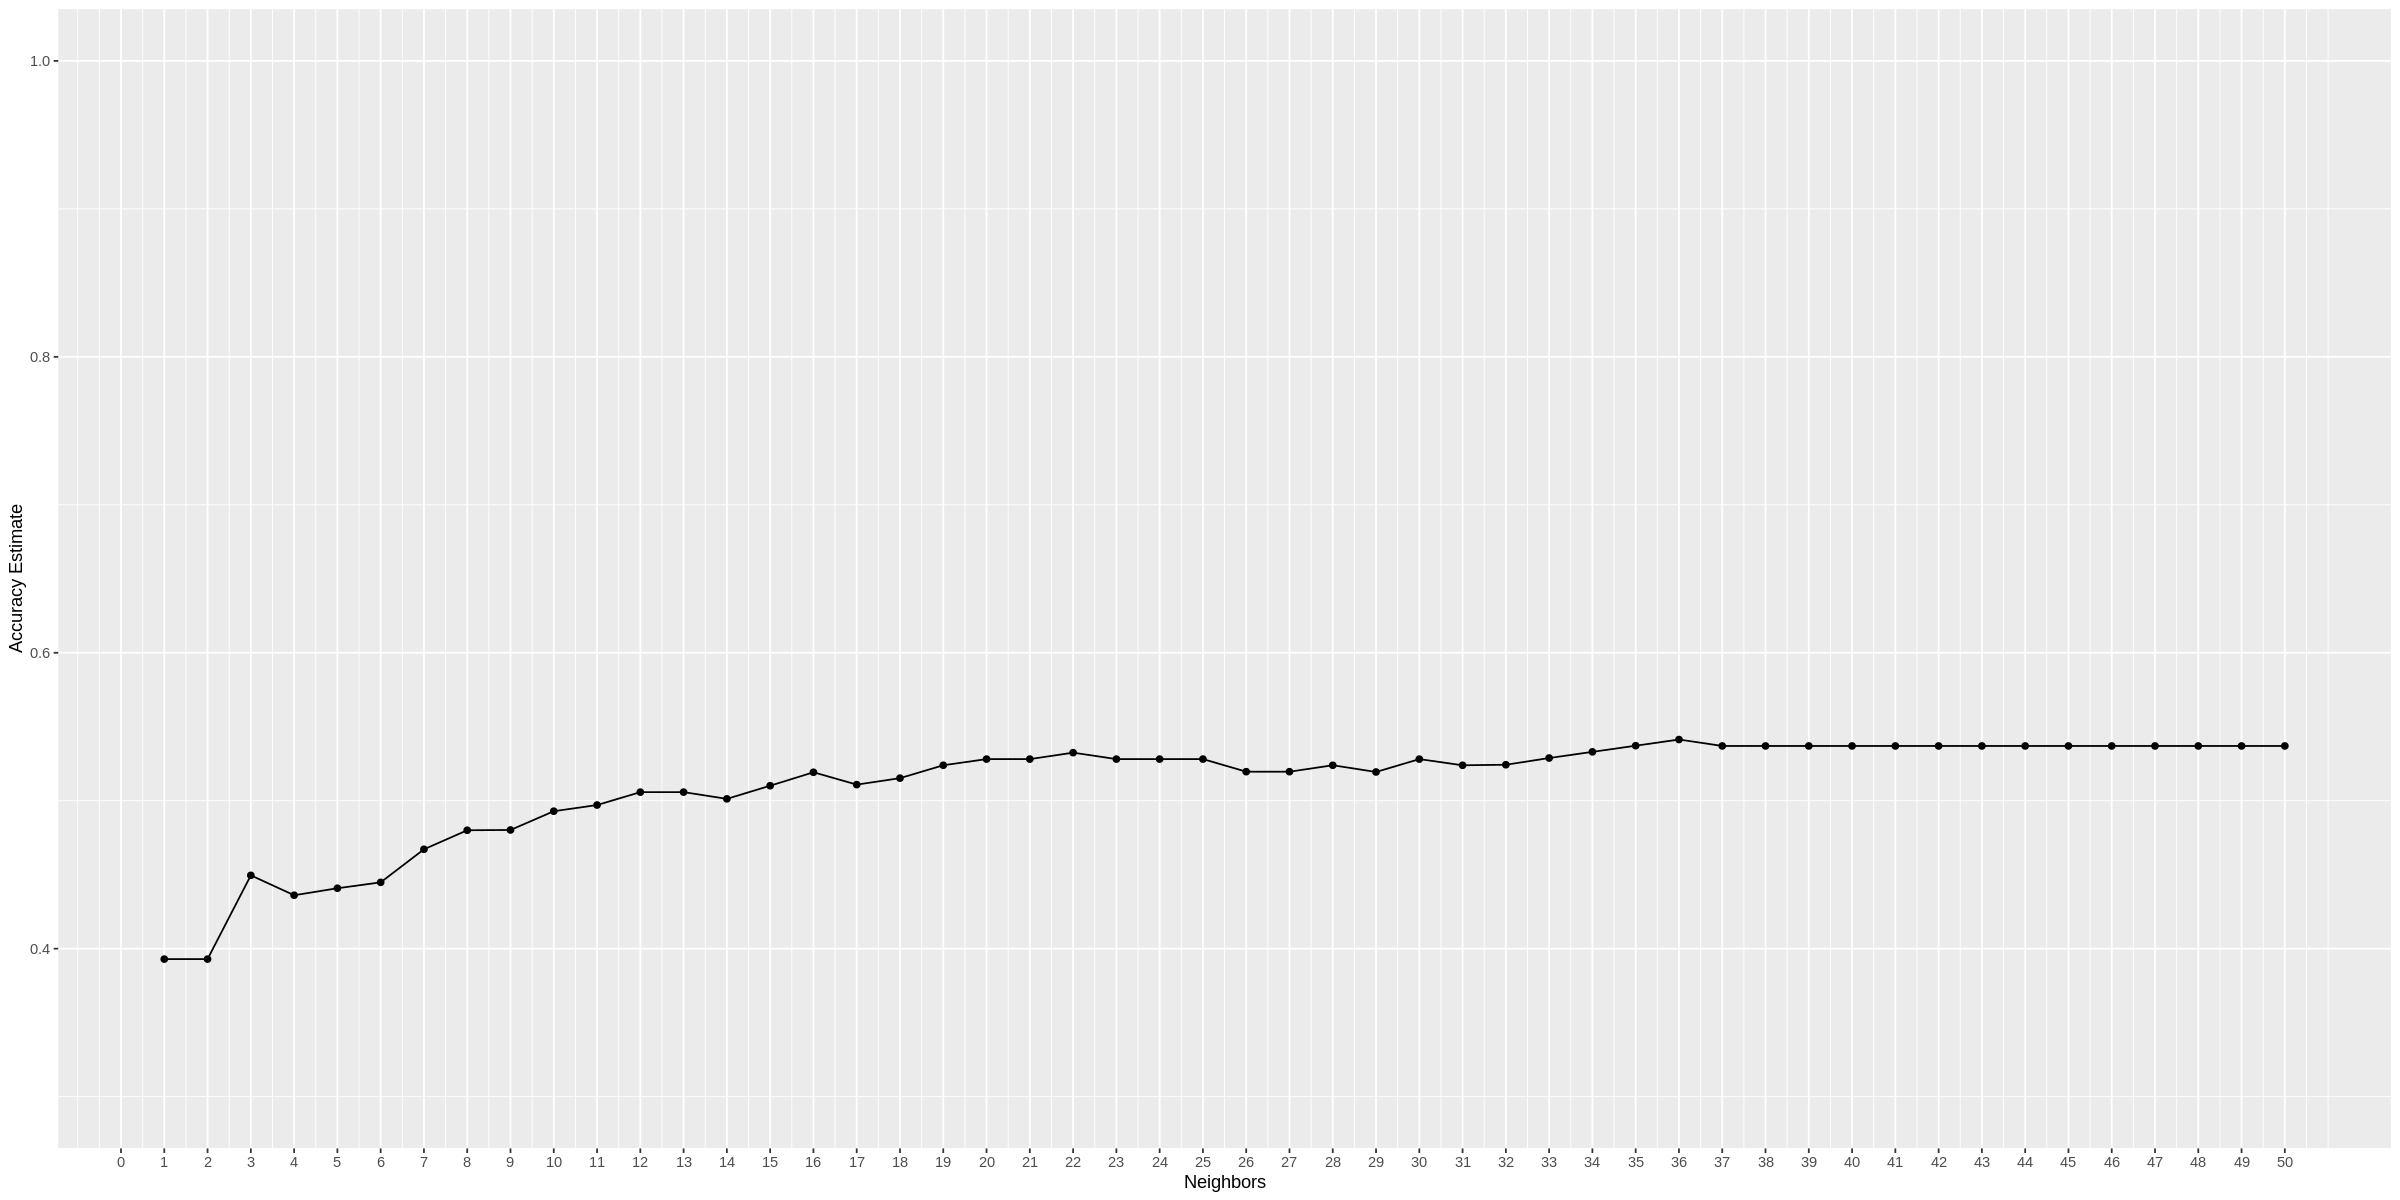

In [16]:
# accuracies plot for different values of k:

options(repr.plot.height = 10, repr.plot.width = 20)

accuracies <- knn_results %>% 
       filter(.metric == 'accuracy')

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 50, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.3, 1.0)) # adjusting the y-axis

accuracies
accuracy_versus_k
